# Graph Processor

> Take care of graph data

In [ ]:
#| default_exp processor

## graph processor

In [ ]:
#| export
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import warnings
from collections import deque
from tqdm import tqdm
import time
from fastcore.utils import *  # for example: patch

import seaborn as sns
sns.set_theme()

# import dbscan
from sklearn.cluster import DBSCAN
from sklearn.metrics import normalized_mutual_info_score
from scipy.cluster.hierarchy import dendrogram, linkage, maxdists
from sklearn.cluster import AgglomerativeClustering


In [ ]:
#| export
class GraphProcessor:
    def __init__(self, file_path=None):
        self.file_path = file_path
        self.G = None
        self.labels = None
        self.labels_numpy = None
        self.A = None

        # # initialize the graph
        # self.read_graph_from_dot()

    def read_graph_from_dot(self, file_path=None, show_info=True):
        if file_path is None:
            file_path = self.file_path
        if file_path is None:
            raise ValueError("File path not provided.")

        # Read graph from .dot file
        self.G = nx.DiGraph(nx.nx_agraph.read_dot(file_path))  # MultiDiGraph -> DiGraph
        self.labels = {node: self.G.nodes[node]['label'] for node in self.G.nodes}
        # convert labels to numpy int
        self.labels_numpy = np.array([int(self.labels[node]) for node in self.G.nodes])

        # get connection matrix
        num_nodes = len(self.G.nodes)
        nodes = list(self.G.nodes)
        self.A = np.zeros((num_nodes, num_nodes))

        for edge in self.G.edges:
            source = nodes.index(edge[0])
            target = nodes.index(edge[1])
            self.A[source][target] = 1

        if show_info:
            print("Graph loaded from file:", file_path)
            print("Number of nodes:", num_nodes)
            print("Number of edges:", len(self.G.edges))

In [ ]:
# read a graph from file
temp_path = f'../data/probabilistic5_6.dot'
temp_graph = nx.DiGraph(nx.nx_agraph.read_dot(temp_path))
temp_graph

<networkx.classes.digraph.DiGraph>

In [ ]:
# show the nodes and labels
for idx, node in enumerate(temp_graph.nodes):
    print(node, temp_graph.nodes[node])

0 {'label': '1'}
1 {'label': '1'}
2 {'label': '1'}
3 {'label': '1'}
4 {'label': '1'}
5 {'label': '1'}
6 {'label': '2'}
7 {'label': '2'}
8 {'label': '2'}
9 {'label': '2'}
10 {'label': '2'}
11 {'label': '2'}
12 {'label': '3'}
13 {'label': '3'}
14 {'label': '3'}
15 {'label': '3'}
16 {'label': '3'}
17 {'label': '3'}
18 {'label': '4'}
19 {'label': '4'}
20 {'label': '4'}
21 {'label': '4'}
22 {'label': '4'}
23 {'label': '4'}
24 {'label': '5'}
25 {'label': '5'}
26 {'label': '5'}
27 {'label': '5'}
28 {'label': '5'}
29 {'label': '5'}


In [ ]:
# convert labels to numpy
labels = {node: temp_graph.nodes[node]['label'] for node in temp_graph.nodes}
# convert labels to numpy int
labels_numpy = np.array([int(labels[node]) for node in temp_graph.nodes])

labels_numpy

array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5])

In [ ]:
# create a graph processor object
temp_path = f'../data/probabilistic5_6.dot'
graph1 = GraphProcessor(file_path = temp_path)

graph1.read_graph_from_dot()

Graph loaded from file: ../data/probabilistic5_6.dot
Number of nodes: 30
Number of edges: 170


In [ ]:
# get the adjacency matrix from the graph
graph1.A.shape

(30, 30)

In [ ]:
#| export
# get the ground truth labels
@patch
def get_groundtruth_labels(self:GraphProcessor, dtype='numpy'):
    # Get groundtruth labels from node attributes
    if self.G is not None:
        if dtype == 'dict':
            return self.labels
        elif dtype == 'numpy':
            return self.labels_numpy
    else:
        print("Graph not yet loaded. Call read_graph() first.")
        return None


In [ ]:

print(graph1.get_groundtruth_labels(dtype = 'numpy'))
print(graph1.get_groundtruth_labels(dtype = 'dict'))

[1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4 5 5 5 5 5 5]
{'0': '1', '1': '1', '2': '1', '3': '1', '4': '1', '5': '1', '6': '2', '7': '2', '8': '2', '9': '2', '10': '2', '11': '2', '12': '3', '13': '3', '14': '3', '15': '3', '16': '3', '17': '3', '18': '4', '19': '4', '20': '4', '21': '4', '22': '4', '23': '4', '24': '5', '25': '5', '26': '5', '27': '5', '28': '5', '29': '5'}


In [ ]:
#| export
# visualize the graph
@patch
def visualize_graph(self:GraphProcessor, group_labels = None, graph_layout=0):
    # Visualize the graph
    colorbar = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'black', 'pink', 'brown', 'gray']
    if self.G is not None:
        layout_list = [nx.spring_layout, nx.circular_layout, nx.spectral_layout, nx.shell_layout, nx.kamada_kawai_layout]
        pos = layout_list[graph_layout](self.G)

        if group_labels is None:
            node_color = 'skyblue'
        else:
            node_color = [colorbar[idx] for idx in (group_labels - group_labels.min())]

        nx.draw_networkx_nodes(self.G, pos, node_size=300, node_color=node_color, alpha=0.7)
        nx.draw_networkx_edges(self.G, pos, arrowstyle='-|>', arrowsize=10, edge_color='gray', alpha=0.5)
        nx.draw_networkx_labels(self.G, pos, font_size=10, font_color='black')
    else:
        print("Graph not yet loaded. Call read_graph() first.")

Graph loaded from file: ../data/probabilistic5_6.dot
Number of nodes: 30
Number of edges: 170
true labels: [1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4 5 5 5 5 5 5]


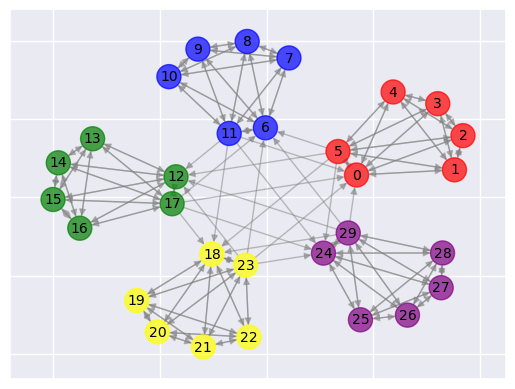

In [ ]:
temp_path = f'../data/probabilistic5_6.dot'
# temp_path = f'../data/chain_mixed5_6.dot'
# temp_path = f'../data/chain_mixed5_60.dot'

graph1 = GraphProcessor(file_path = temp_path)

graph1.read_graph_from_dot()
groundtruth_labels = graph1.get_groundtruth_labels()
print("true labels:", groundtruth_labels)
graph1.visualize_graph(group_labels = groundtruth_labels, graph_layout=4)

In [ ]:
#| export
# get the connection matrix A
@patch
def get_connection_matrix(self:GraphProcessor):
    # Generate connection matrix A
    if self.A is not None:
        return self.A
    else:
        print("Graph not yet loaded. Call read_graph() first.")
        return None

<Axes: >

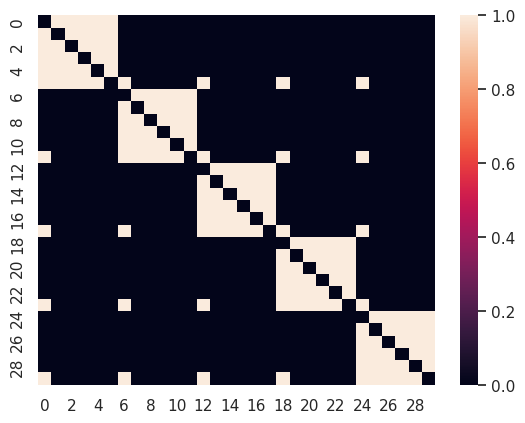

In [ ]:
sns.heatmap(graph1.get_connection_matrix())

In [ ]:
#| export
# Set graph from adjacency matrix
@patch
def set_graph_from_adjacency_matrix(self:GraphProcessor, A):
    # Set graph from adjacency matrix
    self.A = A
    self.G = nx.DiGraph(A)
    self.labels = {node: i for i, node in enumerate(self.G.nodes)}
    self.labels_numpy = np.array([int(self.labels[node]) for node in self.G.nodes])

(30, 30)


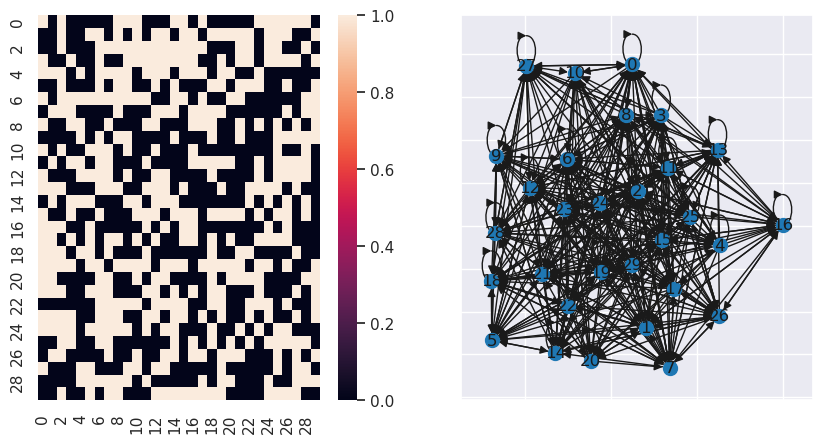

In [ ]:
# A = np.random.randn(30,30)
A = np.random.choice([0,1], (30,30))
print(A.shape)
graph1.set_graph_from_adjacency_matrix(A)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(graph1.get_connection_matrix(), ax=axs[0])
axs[1] = graph1.visualize_graph()

In [ ]:
#| export
# ccreate a random walk on the graph for generating trajectories(Syncmap data)
@patch
def random_walk_on_graph(self:GraphProcessor, connection_matrix=None, L=3000, reset_time=None):
    if connection_matrix is None:
        connection_matrix = self.A

    num_nodes = connection_matrix.shape[0]

    # Find nodes with no outgoing connections
    no_outgoing = np.where(np.sum(connection_matrix, axis=1) == 0)[0]
    if len(no_outgoing) != 0:
        warnings.warn("Some nodes have no outgoing connections.")

    starting_node = np.random.choice(num_nodes)

    while starting_node in no_outgoing:
        warnings.warn("Starting node has no outgoing connections. Choosing another node.")
        starting_node = np.random.choice(num_nodes)

    trajectory = []
    one_hot_vectors = []

    current_node = starting_node
    steps_since_reset = 0

    print("Random walk starting node:", current_node)

    for _ in tqdm(range(L)):
        # Record current node index
        trajectory.append(current_node)

        # Generate one-hot vector for current node
        one_hot = np.zeros(num_nodes, dtype=np.bool_)
        one_hot[current_node] = True
        one_hot_vectors.append(one_hot)

        # Choose next node based on outgoing connections
        if np.sum(connection_matrix[current_node]) == 0 or (
                reset_time is not None and steps_since_reset == reset_time):
            current_node = np.random.choice(num_nodes)
            warnings.warn("No outgoing connections from current node. Choosing another node.")
            steps_since_reset = 0
        else:
            prob = connection_matrix[current_node] / np.sum(connection_matrix[current_node])
            current_node = np.random.choice(num_nodes, p=prob)
            steps_since_reset += 1

    return np.array(trajectory), np.array(one_hot_vectors)


In [ ]:
# regenerate the graph
temp_path = f'../data/probabilistic5_6.dot'
graph1 = GraphProcessor(file_path = temp_path)

graph1.read_graph_from_dot()

Graph loaded from file: ../data/probabilistic5_6.dot
Number of nodes: 30
Number of edges: 170


In [ ]:
traj, one_hot = graph1.random_walk_on_graph(L = 300)

Random walk starting node: 6


100%|██████████| 300/300 [00:00<00:00, 39496.87it/s]


(300,)


<Axes: >

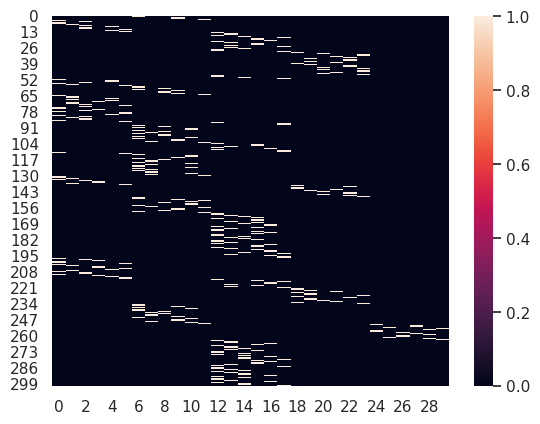

In [ ]:
print(traj.shape)
sns.heatmap(one_hot)

## 

## Working memory processor

In [ ]:
#| export
class WorkingMemProcessor:
    def __init__(self, state_memory, input_size=None, time_delay=0):
        self.state_memory = state_memory
        self.input_size = input_size
        self.time_delay = time_delay

        self.working_memory = deque(maxlen=self.state_memory)

    def set_input_size(self, input_size):
        self.input_size = input_size

    def set_time_delay(self, time_delay):
        self.time_delay = time_delay

    def seq_gen_naive(self, input_seq, verbose = False):
        # input_seq is shaped as (seq_len, input_size)
        if input_seq.shape[1] != self.input_size:
            # update input_size
            self.set_input_size(input_seq.shape[1])
            if verbose:
                print("Input size updated to {}.".format(self.input_size))
            # warnings.warn("Input size updated to {}.".format(self.input_size))
                print("generate sequence...")
        # print("generate sequence...")
        time.sleep(0.1)
        output_seq = []
        for i_state in tqdm(range(len(input_seq))):
            state = input_seq[i_state]
            self.working_memory.append(state)
            # convert to numpy
            current_working_mem = np.asarray(self.working_memory)
            current_working_mem = np.sum(current_working_mem, axis=0).astype(np.bool_)

            # append to output_seq
            output_seq.append(current_working_mem)

        return np.asarray(output_seq)
    
    def __repr__(self):
        return f"Working Memory Processor: state_memory={self.state_memory}, input_size={self.input_size}, time_delay={self.time_delay}"

generate graph

In [ ]:
temp_path = f'../data/probabilistic5_6.dot'
graph1 = GraphProcessor(file_path = temp_path)
graph1.read_graph_from_dot()
traj, one_hot = graph1.random_walk_on_graph(L = 250)

Graph loaded from file: ../data/probabilistic5_6.dot
Number of nodes: 30
Number of edges: 170
Random walk starting node: 19


100%|██████████| 250/250 [00:00<00:00, 28517.16it/s]


In [ ]:
state_memory = 2
seq_generator = WorkingMemProcessor(state_memory=state_memory)
input_seq = seq_generator.seq_gen_naive(input_seq=one_hot)

100%|██████████| 250/250 [00:00<00:00, 174500.92it/s]


<Axes: >

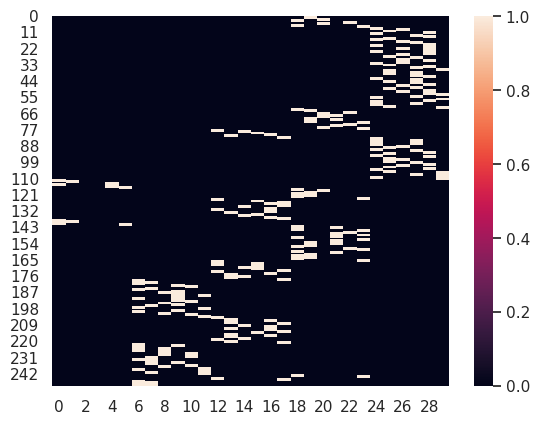

In [ ]:
sns.heatmap(input_seq)

## Clustering

In [ ]:
#| export
class Readout:
    def __init__(self, input_map=None, input_matrix=None, ground_truth=None):
        self.input_map = input_map
        self.input_matrix = input_matrix
        self.ground_truth = ground_truth
        self.predicted_labels = None
        self.NMI = None

    def cal_NMI(self, print_result=True):
        if self.predicted_labels is None:
            print("No predicted labels found. Run dbscan_() first.")
            return None
        # Calculate NMI
        self.NMI = normalized_mutual_info_score(self.ground_truth, self.predicted_labels)
        if print_result:
            print("NMI: ", self.NMI)
        return self.NMI

    def dbscan_(self, map=None, eps=0.1, min_samples=2, print_result=True):
        if map is None:
            map = self.input_map
        # DBSCAN clustering
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(map)
        self.predicted_labels = clustering.labels_
        if print_result:
            print("DBSCAN clustering done. Data updated.")
            print("Predicted labels: ", self.predicted_labels)
            print("Ground truth: ", self.ground_truth)
        return self.predicted_labels


    def hierarchical_organize(self, map=None, hierarchy=None, method='ward', print_result=True):
        if map is None:
            map_ = self.input_map
        else:
            map_ = map
        input_size = map_.shape[0]
        # method = "single"
        Z = linkage(map_, method)
        # fig = plt.figure(dpi=150)
        # label_list = [i for i in range(1, self.input_size+1)]
        # dendrogram(Z, color_threshold=0, above_threshold_color='k', labels=label_list)
        # dendrogram(Z, labels=label_list)

        Z_maxdists = maxdists(Z)
        d_diff_list = []
        for d in range(len(Z_maxdists) - 1):
            d_diff = Z_maxdists[d + 1] - Z_maxdists[d]
            d_diff_list.append(d_diff)

        d_diff_index = np.argsort(d_diff_list)[::-1]

        max_diff = d_diff_index[0]
        tmp_d_diff_index = [max_diff]
        for d in d_diff_index[1:]:
            if max_diff > d:
                max_diff = d
                tmp_d_diff_index.append(d)
        d_diff_index = tmp_d_diff_index

        total_hierarchy = len(d_diff_index)
        if hierarchy is not None:
            total_hierarchy = hierarchy

        labels = np.empty((total_hierarchy, input_size), dtype=int)
        for h in range(total_hierarchy):
            label = [-1 for _ in range(input_size)]
            if h < len(d_diff_index):
                n_cluster = input_size - d_diff_index[h] - 1
                label = AgglomerativeClustering(n_clusters=n_cluster, linkage=method).fit_predict(map_)
            labels[h, :] = label

        # self.labels = np.flip(labels, axis=0)
        self.labels = labels
        self.Z_linkage = Z
        print("Hierarchical clustering done. Data updated.")
        if print_result:
            print("Ground truth: ", self.ground_truth)
            print("Labels: ", self.labels)

        return self.labels

    def plot_dendrogram(self, Z=None, isPlotLabel=False, labels=None):
        if Z is None:
            Z = self.Z_linkage
            if Z is None:
                Z = linkage(self.input_map, 'ward')
        if labels is None:
            labels = self.labels

        fig = plt.figure(dpi=150)
        label_list = [i for i in range(1, labels.shape[1] + 1)]
        if isPlotLabel:
            label_list = labels[0, :]
            dendrogram(Z, color_threshold=0, above_threshold_color='k', labels=np.array(label_list))
        else:
            dendrogram(Z)
        plt.show()
        return None